# Third Experiment
In this run, we investigate deep mutual learning 

We use 5 students and train them, like described [here](https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Deep_Mutual_Learning_CVPR_2018_paper.pdf). So we use the direct label loss to evaluate the best performing network and then calculate the loss of the other students accordingly.

In [1]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff

from models.pdd_net.pdd_student import OBELISK2d

mode = "DML"
# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f8c488fa730>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [2]:
def update_sheet(epochs, optim, loss,grad_accum,lr, mode, eval_mean_dice, unwarped_dice,var, notes=''):
    """
    function to update a csv table to keep track of results
    """
    df = pd.read_csv('experiments.csv')
    df = df.drop('Unnamed: 0', axis=1)
    df = df.append({
        'epochs':epochs,
        'optim':optim,
        'batch size': grad_accum,
        'learning rate': lr,
        'loss':loss,
        'mode': mode,
        'Eval mean dice': eval_mean_dice,
        'Var eval dice': var,
        'unwarped dice': unwarped_dice,
        'time': datetime.now().strftime("%d.%m.%y %H:%M"),
        'notes': notes
    }, ignore_index=True)
    df.to_csv('experiments.csv')
    print('updated')

# Data

In [3]:
imgs2 = torch.load('/share/data_ultraschall/nicke_ma/data/train_frames_disp_6.pth')
segs2 = torch.load('/share/data_ultraschall/nicke_ma/data/train_segs_disp_6.pth')

imgs3 = torch.load('/share/data_ultraschall/nicke_ma/data/frames_oneFixed_multipleMoving.pth')
segs3 = torch.load('/share/data_ultraschall/nicke_ma/data/segs_oneFixed_multipleMoving.pth')

imgs = torch.cat((imgs2,imgs3))
segs = torch.cat((segs2,segs3))
#define a training split 
torch.manual_seed(42)
# Now, we prepare our train & test dataset.
train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

test_set = torch.arange(len(imgs))
for idx in train_set:
    test_set = test_set[test_set != idx]


print(f"{train_set.shape[0]} train examples")
print(f"{test_set.shape[0]} test examples")

3020 train examples
159 test examples


# Student

In [4]:
W,H = (150,150)
o_m = H//4 +1
o_n = W//4 +1
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2).cuda()

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features

In [5]:
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

# Eval function

In [6]:
def evaluate_model(model):
    model.eval()
    overall_dice = []
    unwarped_dice = []
    
    for i,idx in enumerate(test_set):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].long().contiguous()
        moving_seg = segs[idx:idx+1,1,:].long().contiguous()
        
        # Some images have no segmentation to them, 
        # even if it was present in the directory
        # We leave these ones out, as they cannot be avaluated
        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
            moving_seg = moving_seg*2
        else:
        
            with torch.no_grad():
                fixed_feat = model(fixed.cuda())
                moving_feat = model(moving.cuda())

            ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
            #regularise using meanfield inference with approx. min-convolutions
            soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)
            #upsample field to original resolution
            dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


            #apply and evaluate transformation
            identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
            warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

            d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),3)
            d2 = dice_coeff(fixed_seg, moving_seg, 3)
            
            overall_dice.append(d1.mean())
            unwarped_dice.append(d2.mean())
    
    overall_dice = torch.from_numpy(np.array(overall_dice))
    unwarped_dice = torch.from_numpy(np.array(unwarped_dice))
    return overall_dice.mean(), unwarped_dice.mean()

    #print(f"This model has an average Dice of {round(overall_dice.mean().item(), 5)} mit Variance: {round(overall_dice.var().item(), 5)}. The unwarped Mean dice is: {round(unwarped_dice.mean().item(), 5)} with Var {round(unwarped_dice.var().item(),5)}")

# Setting Parameters

In [7]:
disp_hw = 5
displace_range = 11

epochs = 100
lr = 0.002
# minibatch training
grad_accum = 20

# Experiment 3.1
Deep mutual learning with label loss

In [8]:
num_students = 5
students = []#torch.zeros(num_students, dtype=torch.nn.Module)#torch.zeros(num_students)
optims = []#torch.zeros(num_students)

for i in range(num_students):
    student = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(32),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.PReLU(),
                          torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                          torch.nn.Sigmoid())
    init_weights(student)
    student.train().cuda()
    
    optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)
    
    students.append(student)
    optims.append(optimizer)
#loss_array = torch.from_numpy(np.array([[0 for x in range(epochs)] for i in range(num_students)])).float()

In [9]:
losses = torch.zeros(num_students,epochs)
accs = torch.zeros(num_students, epochs)
unwarped_dice = torch.zeros(num_students, epochs)

for epoch in tqdm(range(epochs)):
    # Cross Validation
    train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

    test_set = torch.arange(len(imgs))
    for idx in train_set:
        test_set = test_set[test_set != idx]
    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # store the loss for all train image pairs
    tmp_loss = torch.zeros(num_students, train_set.size(0))
    
    # show all examples to model
    for i, rnd_idx in enumerate(rnd_train_idx):
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()
        
        # Label preparation
        C1,Hf,Wf = moving_seg.size()
        label_moving = F.one_hot(moving_seg,num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving,size=(Hf//4 +1,Wf//4 +1),mode='bilinear')
        label_fixed = F.one_hot(fixed_seg,num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4 +1,Wf//4 +1),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1).cuda()
    
        outputs = []
        warped_labels = []
        
        fixed = Variable(fixed.cuda())
        moving = Variable(moving.cuda())
        
        # Forward pass
        for stud in students:
            
            feat_fixed = stud(fixed)
            feat_moving = stud(moving)

            ssd_distance = correlation_layer(displace_range, feat_moving, feat_fixed)
            soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)
            
            # append the output
            outputs.append([soft_cost, disp_xy])
            
            label_warped = torch.sum(soft_cost.t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
            
            # store the warped prediction of the student
            warped_labels.append(label_warped.cpu())
        
        # Backward pass
        for idx, stud in enumerate(students):
            
            # calculate the individual label loss
            label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-warped_labels[idx].reshape(3,-1),2),0)
            
            loss_between_students = 0
            for run_idx in range(num_students):
                if idx != run_idx:
                    pred = Variable(warped_labels[run_idx])
                    # cauculate the loss between students
                    loss_between_students += torch.sum(torch.pow(label_distance1 - pred, 2),0)
                    del(pred)
            
            diffloss = 1.5*((outputs[idx][1][0,:,1:,:]-outputs[idx][1][0,:,:-1,:])**2).mean()+\
                       1.5*((outputs[idx][1][0,1:,:,:]-outputs[idx][1][0,:-1,:,:])**2).mean()+\
                       1.5*((outputs[idx][1][0,:,:,1:]-outputs[idx][1][0,:,:,:-1])**2).mean()
            
            loss = diffloss + label_distance1.mean() + (loss_between_students.mean() / (num_students))
            loss.backward()
            tmp_loss[idx][i] += loss.item()

        if (i+1)%grad_accum == 0:
            for optim in optims:
                optim.step()
                optim.zero_grad()
          
    for student_idx,individual_loss in enumerate(tmp_loss):  
        losses[student_idx][epoch] = individual_loss.mean()
    
    #overall_dice = torch.zeros(num_students, epochs)
    #unwarped_dice = torch.zeros(num_students, epochs)
    for student_idx, s in enumerate(students):
        all_dice = []
        unwarped = []
        for i,idx in enumerate(test_set):

            fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
            moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

            fixed_seg = segs[idx:idx+1,0,:].contiguous() * 2
            moving_seg = segs[idx:idx+1,1,:].contiguous() * 2

            if moving_seg.max() <= 0.1 and fixed_seg.max() <= 0.1:
                continue

            with torch.no_grad():
                fixed_feat = s(fixed.cuda())
                moving_feat = s(moving.cuda())

            ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
            #regularise using meanfield inference with approx. min-convolutions
            soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)
            #upsample field to original resolution
            dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


            #apply and evaluate transformation
            identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
            warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

            d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),3)
            d2 = dice_coeff(fixed_seg, moving_seg, 3)

            #print(f"{d1} VS unwarped {d2}; Means: {d1.mean()} VS unwarped {d2.mean()}")
            all_dice.append(d1.mean())
            unwarped.append(d2.mean())

        accs[student_idx][epoch]=torch.from_numpy(np.array(all_dice)).mean()
        unwarped_dice[student_idx][epoch]=torch.from_numpy(np.array(unwarped)).mean()
    
    #print(accs)
    #print(unwarped_dice)
    #print(losses)
    #break
    #if (epoch+1)%10 ==0:
    #    print(f"Epoche: {epoch+1}")
    #    for i in range(num_studs):
    #        print(f"Loss of Student {i} : {loss_array[i][epoch-4:epoch].mean()}")

100%|██████████| 100/100 [4:39:19<00:00, 167.60s/it] 


In [10]:
now = datetime.now().strftime("%d_%m_%y-%H-%M")

<IPython.core.display.Javascript object>


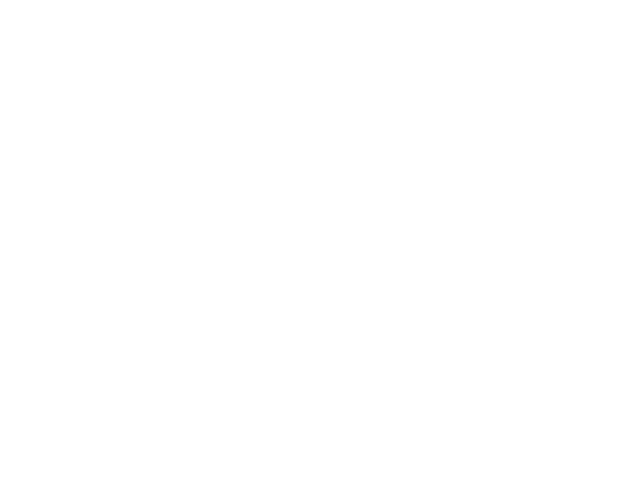

In [11]:
%matplotlib notebook  
fig = plt.figure()
for i in range(num_students):
    plt.plot(losses[i], label=f'Student {i}')
plt.legend()
plt.show()
#plt.savefig(f"plots/dml_loss_{now}.png")

<IPython.core.display.Javascript object>


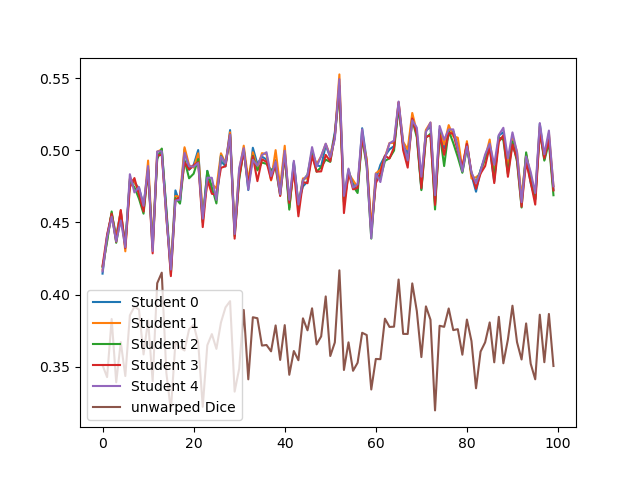

In [12]:
%matplotlib notebook  
fig = plt.figure()
for i in range(num_students):
    plt.plot(accs[i], label=f'Student {i}')
plt.plot(unwarped_dice[i], label=f'unwarped Dice')
plt.legend()
plt.show()
#plt.savefig(f'plots/dml_acc_{now}.png')

In [13]:
eval_mean_dice = [accs[i].mean().item() for i in range(len(accs))]
print(eval_mean_dice)
unwarped_mean_dice = [unwarped_dice[i].mean().item() for i in range(len(unwarped_dice))]
eval_var = [accs[i].var().item() for i in range(len(accs))]

[0.4856196641921997, 0.4868234694004059, 0.48335757851600647, 0.48322921991348267, 0.48645254969596863]


In [14]:
update_sheet(epochs, optims,"Label + diff+ labeldiff between studs",grad_accum,lr, mode, eval_mean_dice, unwarped_dice,eval_var, 'Dataset 3')

updated


In [14]:
os.mkdir(f"models/Experiment_3/{now}")

In [15]:
for i in range(num_students):
    torch.save(students[i].state_dict(), f"models/Experiment_3/{now}/student_16_{i}.pth")

In [16]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [16]:
num_students = 5
students = []#torch.zeros(num_students, dtype=torch.nn.Module)#torch.zeros(num_students)
optims = []#torch.zeros(num_students)

for i in range(num_students):
    student = OBELISK2d(24)
    init_weights(student)
    student.train().cuda()
    
    optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)
    
    students.append(student)
    optims.append(optimizer)
    
loss_array = torch.from_numpy(np.array([[0 for x in range(epochs)] for i in range(num_students)])).float()

In [18]:
for epoch in tqdm(range(epochs)):
    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for rnd_idx in rnd_train_idx:
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()
        
        # Label preparation
        C1,Hf,Wf = moving_seg.size()
        label_moving = F.one_hot(moving_seg,num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving,size=(Hf//4,Wf//4),mode='bilinear')
        label_fixed = F.one_hot(fixed_seg,num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1).cuda()
    
        outputs = []
        warped_labels = []
        fixed = Variable(fixed.cuda())
        moving = Variable(moving.cuda())
        
        # Forward pass
        for stud in students:
            
            feat_fixed = stud(fixed)
            feat_moving = stud(moving)

            ssd_distance = correlation_layer(displace_range, feat_moving, feat_fixed)
            soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
            
            # append the output
            outputs.append([soft_cost, disp_xy])
            
            label_warped = torch.sum(soft_cost.t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
            
            # store the warped prediction of the student
            warped_labels.append(label_warped.cpu())
        
        # Backward pass
        for idx, stud in enumerate(students):
            
            # calculate the individual label loss
            label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-warped_labels[idx].reshape(3,-1),2),0)
            
            loss_between_students = 0
            for run_idx in range(num_students):
                if idx != run_idx:
                    pred = Variable(outputs[run_idx][1])
                    # cauculate the loss between students
                    loss_between_students += torch.sum(torch.pow(outputs[idx][1] - pred, 2))
                    del(pred)
            
            loss = label_distance1.mean() + loss_between_students.mean() / (num_students)
            loss.backward()
            loss_array[idx][epoch] += loss.item()

        if (epoch+1)%grad_accum == 0:
            for optim in optims:
                optim.step()
                optim.zero_grad()

100%|██████████| 100/100 [1:30:04<00:00, 54.05s/it]


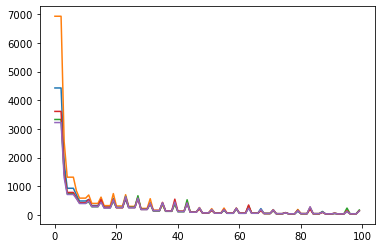

In [19]:
fig = plt.figure()
for i in range(num_students):
    plt.plot(loss_array[i])
plt.savefig("dml_convergence_3_2_100Epochs.png")

In [20]:
for i in range(num_students):
    evaluate_model(students[i])

This model has an average Dice of 0.67598 mit Variance: 0.0635. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.67583 mit Variance: 0.06386. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.67664 mit Variance: 0.06319. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.67507 mit Variance: 0.06376. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.67657 mit Variance: 0.06351. The unwarped Mean dice is: 0.64426 with Var 0.0769


In [21]:
for i in range(num_students):
    torch.save(students[i].state_dict(), f"student_{i}_dml_3_2.pth")

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)